# in-depth analysis with GPs

Given the preliminary results obtained with GPs, which were in comparison more promising than those obtained with NNs, it might be interesting to investigate several questions:

- what is the influence of the input dimensions on the regression results? I.e. how well can we predict alpha from the data from experiment 1 or 2 only. 

# imports

In [1]:
from importlib import reload

In [2]:
import nbhelper
nbhelper = reload(nbhelper)

In [3]:
from nbhelper import *

# data

In [4]:
df0, df1 = get_data()

In [5]:
data0, data1 = prepare_data(df0, df1)

In [6]:
data0.head()

,target,condition,user,dx,dy,vx,vy,cxy
0,1,1,1,-0.024262,0.009825,0.000043,0.000071,0.000006
1,1,1,2,-0.014780,0.031079,0.000083,0.000294,0.000048
2,1,1,3,-0.000615,-0.006961,0.000027,0.000157,-0.000019
3,1,1,4,0.018119,0.026791,0.000059,0.000080,-0.000004
4,1,1,5,-0.001510,0.004122,0.000048,0.000117,-0.000029


In [7]:
data1.head()

,user,target,a-,a+,da
0,1,1,-0.079151,0.018782,0.097933
1,1,2,-0.057142,0.010565,0.067707
2,1,3,-0.050158,-0.017874,0.032284
3,1,4,-0.072195,0.026864,0.099059
4,2,1,-0.124420,-0.038749,0.085671


# plot

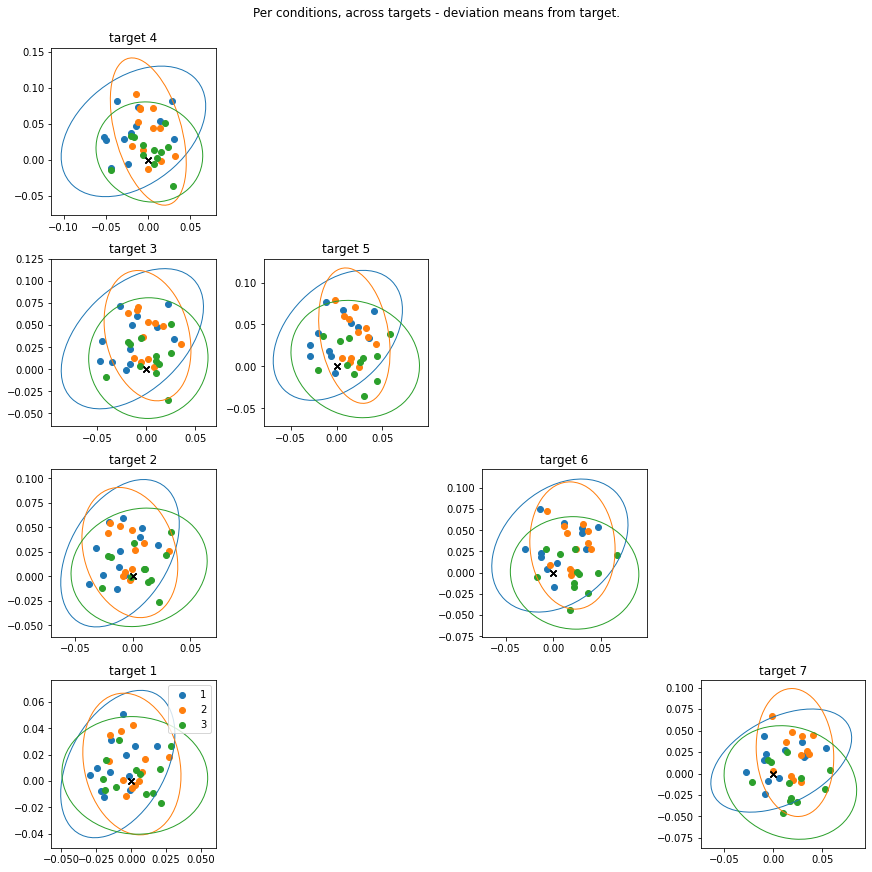

In [8]:
_=plot_data0(data0)

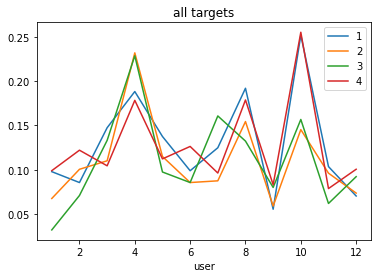

In [9]:
_=plot_data1(data1)

# defining X and y

Here we make some choices about how X and y are defined.
To be precise, we adopt the following mapping:

experiment | 1 | 2
--- | --- | ---
targets mapping | 1,2,3,4 | 1
targets mapping | 5,6,7 | 2,3,4


In [10]:
X, y = get_Xy(data0, data1)

In [11]:
X.head()

,target,user,dx1,dx2,dx3,dy1,dy2,dy3,vx1,vx2,vx3,vy1,vy2,vy3,cxy1,cxy2,cxy3
0,1,1,-0.024262,-0.015546,0.010835,0.009825,0.035169,-0.009992,0.000043,0.000034,0.000039,0.000071,0.000146,0.000081,0.000006,-0.000039,0.000028
1,1,2,-0.014780,-0.016146,0.006337,0.031079,0.015193,0.005324,0.000083,0.000054,0.000047,0.000294,0.000107,0.000080,0.000048,-0.000003,0.000023
2,1,3,-0.000615,0.009714,0.028480,-0.006961,0.016496,0.026709,0.000027,0.000113,0.000062,0.000157,0.000130,0.000138,-0.000019,-0.000021,-0.000015
3,1,4,0.018119,0.026638,0.021450,0.026791,0.018427,-0.016527,0.000059,0.000072,0.000073,0.000080,0.000118,0.000206,-0.000004,0.000009,0.000043
4,1,5,-0.001510,0.000741,0.015506,0.004122,-0.005080,-0.008956,0.000048,0.000064,0.000049,0.000117,0.000074,0.000058,-0.000029,-0.000027,0.000009


In [12]:
y.head()

,target,user,da
0,1,1,0.097933
1,1,2,0.085671
2,1,3,0.147423
3,1,4,0.188232
4,1,5,0.137563


# validate

The validation of an hypothesis is related to the relative performance of the classifier, and its ability to generalise. The performance of the classifier is computed with the full dataset in regression, while the generasibility is computed with a cross-validation.

In [125]:
def test_hypothesis(columns=['target', 'user', 
                             'dx1', 'dx2', 'dx3', 'dy1', 'dy2', 'dy3', 
                             'vx1','vx2', 'vx3', 'vy1', 'vy2', 'vy3', 'cxy1', 'cxy2', 'cxy3'], 
                    n_splits=4, n_repeats=3):
    
    kernel = GPy.kern.RBF(input_dim=len(columns)-2, variance=1., lengthscale=1.)
    
    # performance with full data
    Xfull = select(X[columns], target=[3,5,6,7]).iloc[:, 2:]
    yfull = select(y, target=[3,5,6,7])['da']
    yfull = pd.DataFrame(yfull)

    m = GPy.models.GPRegression(Xfull.values,yfull.values.reshape(-1,1),kernel)
    m.optimize(messages=False)
    y_pred, yv_pred = m.predict(Xfull.values)

    nfull = np.linalg.norm(y_pred - yfull.values, axis=1)
    
    # cross-validated performance
    rkf = RepeatedKFold(n_splits=4, n_repeats=3, random_state=1234)
    res = []
    for train, test in rkf.split(np.arange(1,13)):
        Xtrain = select(X[columns], target=[3,5,6,7], user=list(train)).iloc[:, 2:]
        Xtest = select(X[columns], target=[3,5,6,7], user=list(test)).iloc[:, 2:]

        ytrain = select(y, target=[3,5,6,7], user=list(train))['da']
        ytrain = pd.DataFrame(ytrain)
        ytest = select(y, target=[3,5,6,7], user=list(test))['da']
        ytest = pd.DataFrame(ytest)

        m = GPy.models.GPRegression(Xtrain.values,ytrain.values.reshape(-1,1),kernel)
        m.optimize(messages=False)
        y_pred, yv_pred = m.predict(Xtest.values)

        n = np.linalg.norm(y_pred - ytest.values, axis=1)
        res.append(n.mean())
    res = np.array(res)
    
    return {'rmse_full_mean': nfull.mean(), 'rmse_full_std': nfull.std(), 
     'rmse_cv_mean': res.mean(), 'rmse_cv_std': res.std()}

In [126]:
X.columns

Index(['target', 'user', 'dx1', 'dx2', 'dx3', 'dy1', 'dy2', 'dy3', 'vx1',
       'vx2', 'vx3', 'vy1', 'vy2', 'vy3', 'cxy1', 'cxy2', 'cxy3'],
      dtype='object')

We can now investigate the influence of the input dimension on the performance.

In [127]:
test_hypothesis()

{'rmse_full_mean': 0.03124975918411144,
 'rmse_full_std': 0.024470047612942004,
 'rmse_cv_mean': 0.056044897526592974,
 'rmse_cv_std': 0.017675722050914004}

In [128]:
test_hypothesis(columns=['target', 'user', 
                         'dx1', 'dx2', 'dx3', 'dy1', 'dy2', 'dy3',])

{'rmse_full_mean': 0.03125022866658527,
 'rmse_full_std': 0.02447089177891429,
 'rmse_cv_mean': 0.056042986127288114,
 'rmse_cv_std': 0.017678025686997507}

In [129]:
test_hypothesis(columns=['target', 'user', 
                         'vx1', 'vx2', 'vx3', 'vy1', 'vy2', 'vy3',])

{'rmse_full_mean': 0.04029681726823764,
 'rmse_full_std': 0.03160672764856599,
 'rmse_cv_mean': 0.04395362930669316,
 'rmse_cv_std': 0.013198124176230983}

In [130]:
test_hypothesis(columns=['target', 'user', 
                         'cxy1', 'cxy2', 'cxy3',])

{'rmse_full_mean': 0.040296861431842246,
 'rmse_full_std': 0.031606761038194764,
 'rmse_cv_mean': 0.043953642370166336,
 'rmse_cv_std': 0.013198132453042886}

In [131]:
test_hypothesis(columns=['target', 'user', 
                         'dx1', 
                         'dy1', 
                         'vx1', 
                         'vy1', 
                         'cxy1',])

{'rmse_full_mean': 0.03848153534656016,
 'rmse_full_std': 0.03121778150945382,
 'rmse_cv_mean': 0.04459590492612847,
 'rmse_cv_std': 0.013890617821352442}

In [132]:
test_hypothesis(columns=['target', 'user', 
                         'dx2',
                         'dy2',
                         'vx2',
                         'vy2',
                        'cxy2',])

{'rmse_full_mean': 0.0342812751576248,
 'rmse_full_std': 0.028432154227116705,
 'rmse_cv_mean': 0.0429724852855643,
 'rmse_cv_std': 0.010846466191466833}

In [133]:
test_hypothesis(columns=['target', 'user', 
                         'dx3',
                         'dy3', 
                         'vx3', 
                         'vy3', 
                        'cxy3',])

{'rmse_full_mean': 0.027268433934102127,
 'rmse_full_std': 0.02245991951968952,
 'rmse_cv_mean': 0.04463150837200978,
 'rmse_cv_std': 0.017054979973169803}

In [134]:
test_hypothesis(columns=['target', 'user', 
                         'dx3',
                         'dy3',])

{'rmse_full_mean': 0.027273225991176677,
 'rmse_full_std': 0.02246388694598745,
 'rmse_cv_mean': 0.04463367843749394,
 'rmse_cv_std': 0.017056649356937566}

This shows that using the pointing deviation in the third step of experiment 1 (i.e. $(dx3, dy3)$) provides the best performance.